In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [47]:
fpath = "../../data/DNN_data/v2/"

sig_with_artifact = np.load(fpath + "data_with_non_sine_v2_varying" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


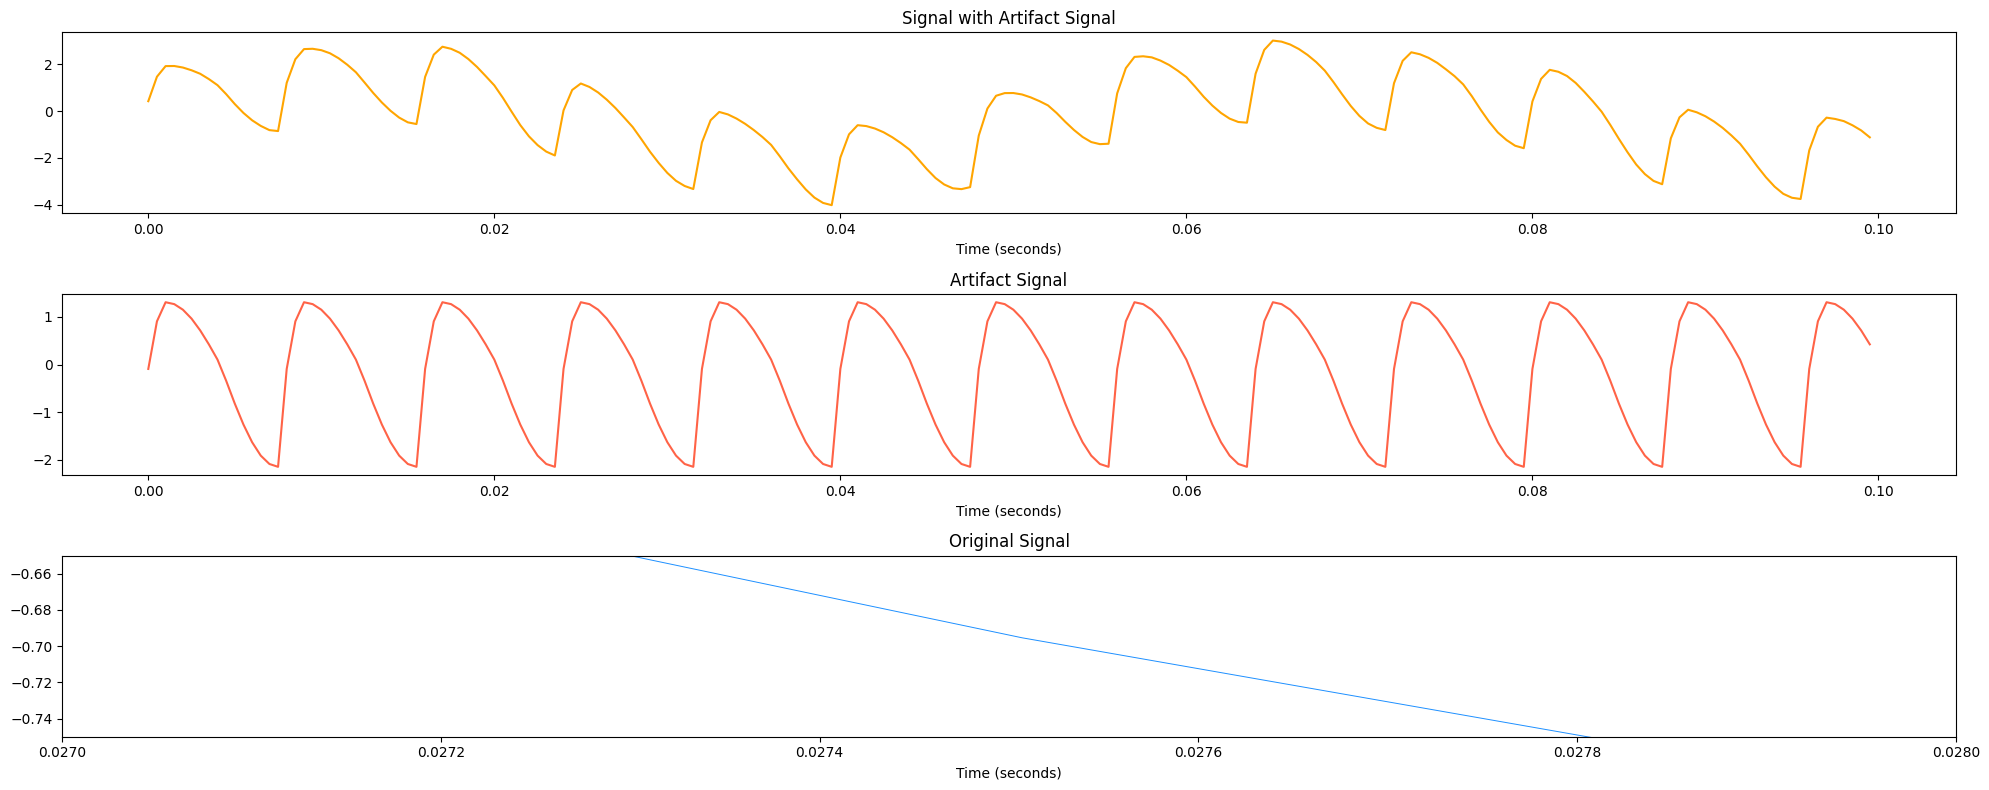

In [48]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,8))
plt.subplot(3, 1, 1)
plt.plot(t[:200], sig_with_artifact[0][:200], color='orange')
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(t[:200], artifact[0][:200], color='tomato')
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t[:200], sig[0][:200], color='dodgerblue', linewidth = 0.7)
plt.xlabel("Time (seconds)")
plt.title('Original Signal')
plt.xlim(0.0270, 0.0280)
plt.ylim(-0.75, -0.65)

plt.tight_layout()

(1000, 4000)
(1000, 4000)


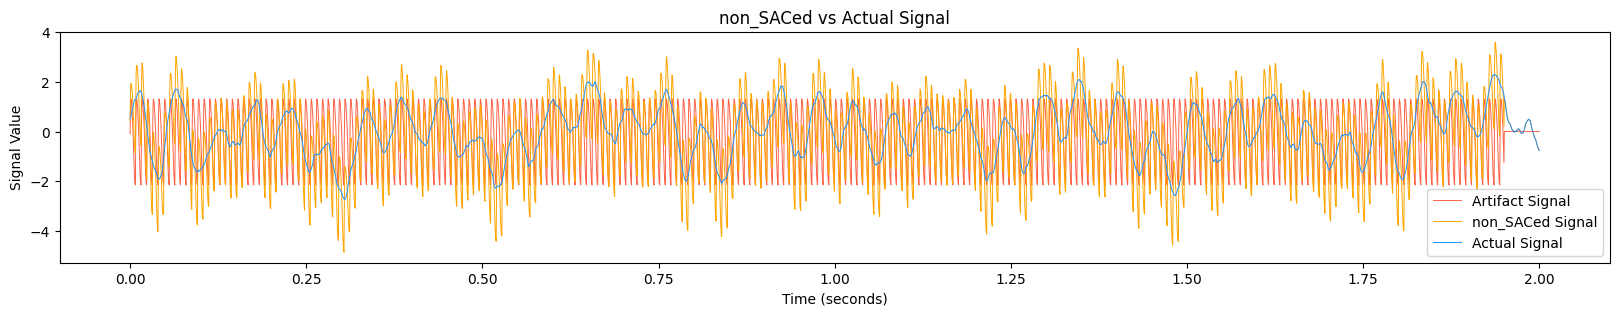

In [49]:
scaler = StandardScaler()

X = scaler.fit_transform(sig_with_artifact.T)
y = (sig.T-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

X = X.T
y = y.T

print(X.shape)
print(y.shape)

plt.figure(figsize=(20, 3))
plt.plot(t, artifact[0], label='Artifact Signal', color='tomato', alpha=1, linewidth=0.7)
plt.plot(t, sig_with_artifact[0], label='non_SACed Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(t, sig[0], label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('non_SACed vs Actual Signal')
plt.legend()
plt.show()

In [50]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))

X_train = X_train.reshape(X_train.shape[0], 4000, 1)
X_test = X_test.reshape(X_test.shape[0], 4000, 1)

print("unsqueezed X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x T, y : B x T
print("unsqueezed X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

X_train shape: (800, 4000)
y_train shape: (800, 4000)
X_test shape: (200, 4000)
y_test shape: (200, 4000)
unsqueezed X_train shape: (800, 4000, 1)
y_train shape: (800, 4000)
unsqueezed X_test shape: (200, 4000, 1)
y_test shape: (200, 4000)


In [51]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes # 클래스 개수
        self.num_layers = num_layers # LSTM 계층의 개수
        self.input_size = input_size # 입력 크기로 훈련 데이터셋의 칼럼 개수를 의미
        self.hidden_size = hidden_size # hidden layer의 뉴런 개수

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # LSTM 계층
        self.fc1 =  nn.Linear(hidden_size, 128) # 완전연결층
        self.fc2 = nn.Linear(128, num_classes) # 출력층

        self.gelu = nn.GELU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
    
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        output = output.reshape(-1, self.hidden_size) # fc layer 적용을 위해 데이터를 1차원 형태로 조정
        out = self.gelu(output)
        out = self.fc1(out)
        out = self.gelu(out)
        out = self.fc2(out)
        return out

In [52]:
# 모델 인스턴스 생성
input_size = 1  # 입력 크기
hidden_size = 16  # 임의의 hidden layer 크기
num_layers = 2  # 임의의 LSTM layer 개수
num_classes = 1  # 출력 크기

model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
print(model)

LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (gelu): GELU(approximate='none')
)


In [53]:
# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
num_epochs = 200

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0]
        y = batch[1]
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        loss = criterion(y_pred, y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 5/200, Loss: 0.08408886939287186
Epoch 10/200, Loss: 0.009506824426352978
Epoch 15/200, Loss: 0.005300845950841904
Epoch 20/200, Loss: 0.004435267765074968
Epoch 25/200, Loss: 0.003967170137912035
Epoch 30/200, Loss: 0.0035219595301896334
Epoch 35/200, Loss: 0.003109920071437955
Epoch 40/200, Loss: 0.0028789816424250603
Epoch 45/200, Loss: 0.0026463300455361605
Epoch 50/200, Loss: 0.0025863810442388058
Epoch 55/200, Loss: 0.0021941838786005974
Epoch 60/200, Loss: 0.002121040830388665
Epoch 65/200, Loss: 0.0018989196978509426
Epoch 70/200, Loss: 0.0020287716761231422
Epoch 75/200, Loss: 0.001717831939458847
Epoch 80/200, Loss: 0.0015778124798089266
Epoch 85/200, Loss: 0.0015557900769636035
Epoch 90/200, Loss: 0.0017066386062651873
Epoch 95/200, Loss: 0.0013063019141554832
Epoch 100/200, Loss: 0.001484759384766221
Epoch 105/200, Loss: 0.0012283644173294306
Epoch 110/200, Loss: 0.0012252338929101825
Epoch 115/200, Loss: 0.0012251067673787475
Epoch 120/200, Loss: 0.001191475545056164

In [54]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T

        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.cpu().view(-1, 4000)), 0)
        Clean = torch.cat((Clean, y.cpu()), 0)

val_loss = criterion(Clean, SACed)
print(f'Validation Loss: {val_loss.item()}')     

Validation Loss: 0.0007761325687170029


Mean Absolute Error: 0.014171382412314415
Mean Squared Error: 0.0005807214183732867


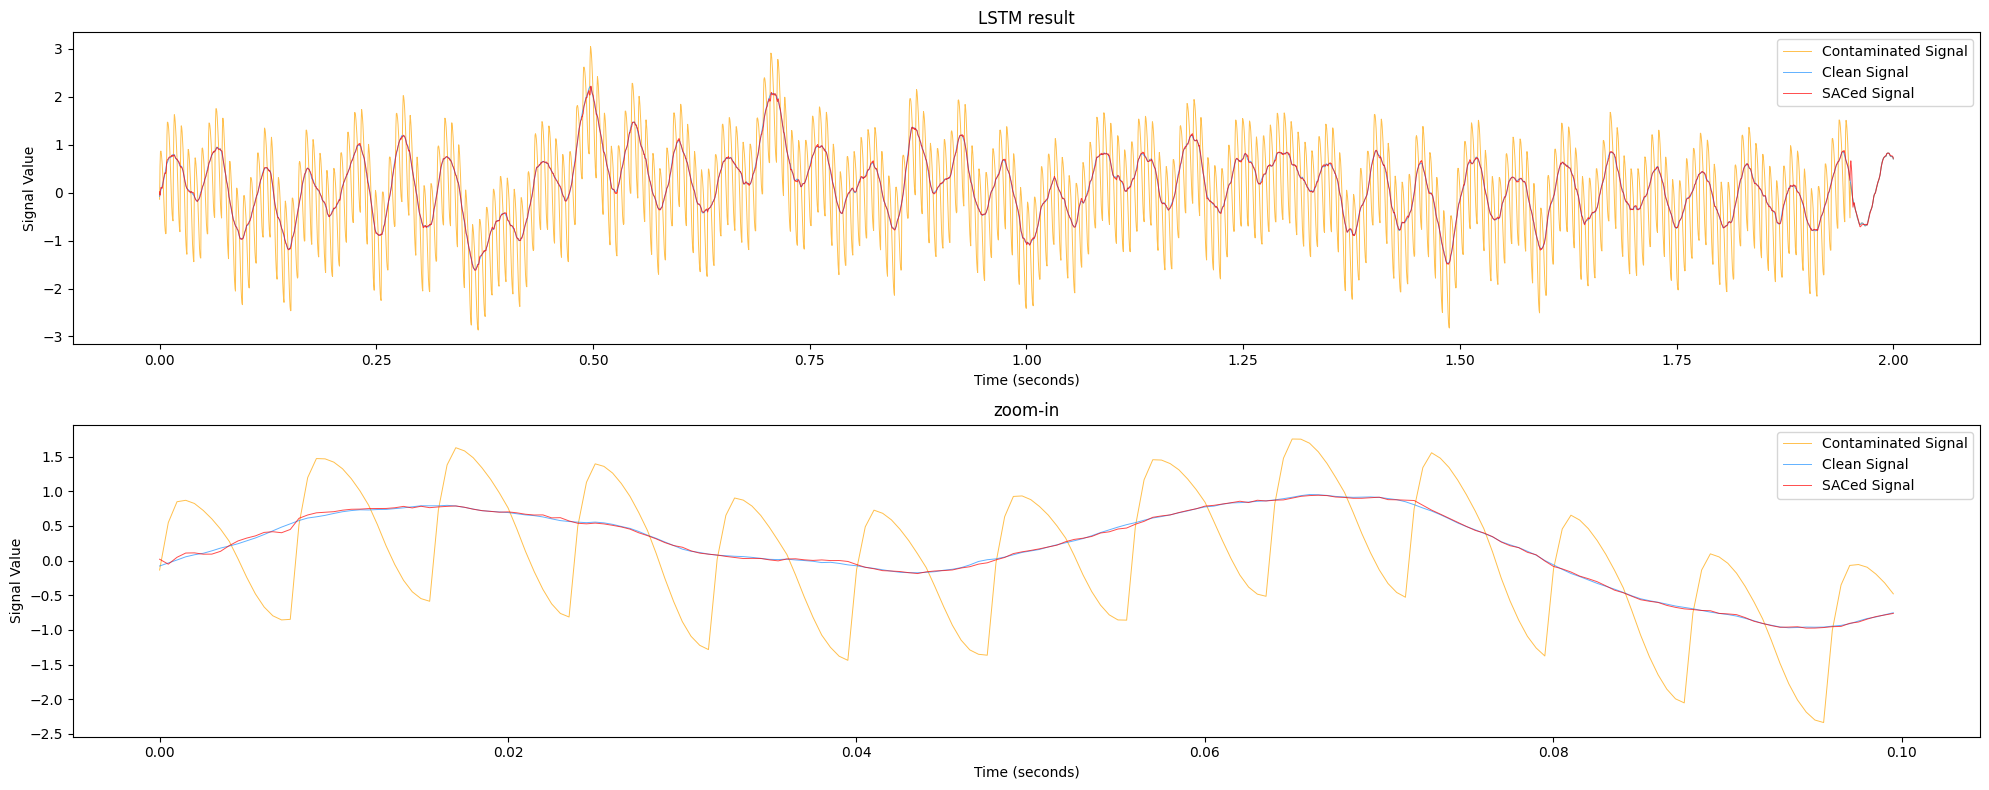

In [55]:
# time domain plotting

Contaminated_signal = Contaminated[0]
SACed_signal = SACed[0]
Clean_signal = Clean[0]

plt.figure(figsize=(20,8))
plt.subplot(2, 1, 1)
plt.plot(t, Contaminated_signal, label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t, Clean_signal, label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t, SACed_signal, label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('LSTM result')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:200], Contaminated_signal[:200], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], Clean_signal[:200], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], SACed_signal[:200], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('zoom-in')
plt.legend()

plt.tight_layout()

print(f"Mean Absolute Error: {mean_absolute_error(Clean_signal, SACed_signal)}")
print(f"Mean Squared Error: {mean_squared_error(Clean_signal, SACed_signal)}")

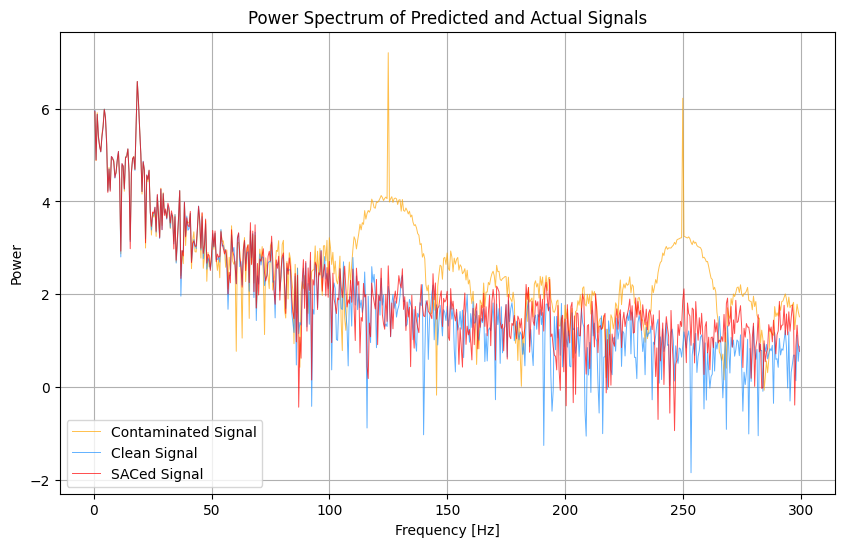

Mean Absolute Error: 0.42774898392601723
Mean Squared Error: 0.34746366380941085


In [56]:
# frequency domain plotting

n = len(SACed_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(SACed_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(Clean_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

fft_nonSACed = np.fft.fft(Contaminated_signal)
fft_nonSACed = np.abs(fft_nonSACed[:n//2])
fft_nonSACed[1:] = 2 * fft_nonSACed[1:]
power_nonSACed = fft_nonSACed**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs[1:600], np.log10(power_nonSACed)[1:600], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_actual)[1:600], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_predicted)[1:600], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")